### Cálculo de la distancia entre líneas consecutivas de la red de difracción

De la ley de Bragg:
$$
\boxed{m \lambda = d \sin \theta} \implies d = \frac{m \lambda}{\sin \theta}
$$

con $m=1$, el error de $d$ es:
$$
\Delta d = \sqrt{\left(\frac{\Delta \lambda}{\sin \theta}\right)^2 + \left(\frac{\lambda \cos \theta}{\sin^2 \theta} \; \Delta\theta\right)^2}
$$

### Cálculo de las longitudes de onda
De la ley de Bragg:
$$
\boxed{m \lambda = d \sin \theta} \implies \lambda = \frac{d \sin \theta}{m}
$$

El error para $\lambda$ es:
$$
\Delta \lambda = \frac{1}{m} \sqrt{\left(\sin \theta \; \Delta d\right)^2 + \left(d \cos \theta \; \Delta\theta\right)^2}
$$

In [1]:
#@title Librerías
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy.stats import t

In [2]:
#@title Clase `experimento`
class experimento:
  def __init__(self, medidas):
    self.order = np.array([medida['m'] for medida in medidas], dtype=np.int16)
    self.abs_order = self.order[self.order > 0]
    self.angles = [np.array(medida['Angulos']) for medida in medidas]
    
    idx = np.argsort(self.order)

    self.order = self.order[idx]
    self.angles = [self.angles[i] for i in idx]
    self.decimal_angles = self.__angles_decimal(medidas)
    self.radian_angles = [np.deg2rad(angles) for angles in self.decimal_angles]
    self.Delta_decimal_angles = 1 / (2 * 60)  # Resolución: 1'
    self.Delta_radian_angles = np.deg2rad(self.Delta_decimal_angles)


  def __angles_decimal(self, medidas):
    decimal_angles = [np.empty(len(medida['Angulos'])) for medida in medidas]

    for i, medida in enumerate(medidas):
      for j, angulo in enumerate(medida['Angulos']):
        degrees, minutes = angulo.split()
        degrees = int(degrees.replace("º", ""))
        minutes = int(minutes.replace("'", ""))
        deg = degrees + minutes/60

        decimal_angles[i][j] = deg

    return decimal_angles


  @property
  def decimal_angles_mean(self):
    if hasattr(self, '_decimal_angles_mean'):
      return self._decimal_angles_mean
    else:
      self._decimal_angles_mean = [(self.decimal_angles[i] + self.decimal_angles[-i-1]) / 2 for i in range(self.order.size // 2)]
      self._decimal_angles_mean = self._decimal_angles_mean[::-1]
      return self._decimal_angles_mean


  @property
  def radian_angles_mean(self):
    if hasattr(self, '_radian_angles_mean'):
      return self._radian_angles_mean
    else:
      self._radian_angles_mean = np.deg2rad(self.decimal_angles_mean)
      return self._radian_angles_mean


  @property
  def lambdas(self):
    if hasattr(self, '_lambdas'):
      return self._lambdas
    else:
      # self.d en este caso debería ser un número, no un arreglo
      self._lambdas = [self.d * np.sin(thetas) / self.abs_order[i] for i, thetas in enumerate(self.radian_angles_mean)]
      return self._lambdas


  @lambdas.setter
  def lambdas(self, lambda_list):
    self._lambdas = np.array(lambda_list, dtype=np.float64)


  @property
  def Delta_lambdas(self):
    if hasattr(self, '_Delta_lambdas'):
      return self._Delta_lambdas
    else:
      # self.d y self.Delta_d en este caso deberían ser números, no arreglos
      self._Delta_lambdas = np.sqrt(
        np.power(self.Delta_d * np.sin(self.radian_angles_mean), 2)
        + np.power(self.d * np.cos(self.radian_angles_mean) * self.Delta_radian_angles, 2)
      )
      return self._Delta_lambdas


  @property
  def d(self):
    if hasattr(self, '_d'):
      return self._d
    else:
      self._d = [abs(self.abs_order[i]) * self.lambdas / np.sin(thetas) for i, thetas in enumerate(self.radian_angles_mean)]
      return self._d


  @d.setter
  def d(self, d):
    self._d = d


  @property
  def Delta_d(self):
    if hasattr(self, '_Delta_d'):
      return self._Delta_d
    else:
      self._Delta_d = abs(self.Delta_radian_angles * self.lambdas * np.cos(self.radian_angles_mean) / np.power(np.sin(self.radian_angles_mean), 2))
      return self._Delta_d


  @Delta_d.setter
  def Delta_d(self, Delta_d):
    self._Delta_d = Delta_d


  @property
  def Delta_d_mean(self):
    if hasattr(self, '_Delta_d_mean'):
      return self._Delta_d_mean
    else:
      _, self._Delta_d_mean = average_and_report(self.d, self.Delta_d)
      return self._Delta_d_mean



In [3]:
#@title Funciones
def average_and_report(x, Delta_X):
  X = deepcopy(x)
  N = np.size(X)
  X_mean = np.mean(X)
  if isinstance(X, list):
    SEM_X_mean2 = np.var(np.concatenate(X).ravel(), ddof=1) / N
  else:
    SEM_X_mean2 = np.var(X, ddof=1) / N

  if N < 30:
    SEM_X_mean2 *= t.ppf(.975, N - 1) ** 2

  Delta_X_mean = np.sqrt(np.mean(Delta_X) ** 2 + SEM_X_mean2)

  return X_mean, Delta_X_mean


def OLS_regr(X, Y, **kwargs):
  """
  Realiza una regresión lineal por mínimos cuadrados ordinarios (OLS).

  Calcula los parámetros `a` y `b` de una recta ajustada `Y = aX + b`, junto con los errores estándar,
  el coeficiente de correlación de Pearson, y opcionalmente, las incertidumbres de los parámetros si se
  proporcionan errores en las variables `X` e `Y`.

  Parameters
  ----------
  X : array_like
      Vector de valores independientes.
  Y : array_like
      Vector de valores dependientes.
  **kwargs : dict, opcional
      Argumentos opcionales que permiten incluir incertidumbres en los datos:

      - 'Delta_X' : array_like
          Errores estándar asociados a cada valor de `X`.
      - 'Delta_Y' : array_like
          Errores estándar asociados a cada valor de `Y`.

  Returns
  -------
  a : float
      Pendiente de la recta ajustada.
  b : float
      Ordenada al origen (intersección con el eje Y).
  SE_a : float
      Error estándar de la pendiente.
  SE_b : float
      Error estándar de la ordenada al origen.
  r : float
      Coeficiente de correlación de Pearson.

  Si se proporcionan `Delta_X` y `Delta_Y`, también se devuelven:

  Delta_a : float
      Incertidumbre en la pendiente considerando los errores en `X` e `Y`.
  Delta_b : float
      Incertidumbre en la ordenada al origen considerando los errores en `X` e `Y`.

  Notes
  -----
  La función implementa una regresión lineal clásica usando el método de mínimos cuadrados.
  Si el número de observaciones es menor a 30, se aplica una corrección de Student para los errores estándar.
  """

  N = len(X)
  SX = np.sum(X)
  SY = np.sum(Y)
  SXX = np.sum(X*X)
  SYY = np.sum(Y*Y)
  SXY = np.sum(X*Y)

  P1 = SX*SY - N*SXY
  P2 = SX*SXY - SY*SXX
  Q = SX**2 - N*SXX

  a = P1/ Q
  b = P2 / Q

  linear_X = a*X + b
  ji2 = np.sum(np.power(Y - linear_X, 2))

  SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
  SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
  r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

  if N < 30:
    SE_a *= t.ppf(.975, N - 1)
    SE_b *= t.ppf(.975, N - 1)

  for key, value in kwargs.items():
    if key == 'Delta_X':
      Delta_X = value
      continue
    elif key == 'Delta_Y':
      Delta_Y = value
      continue
  try:
    Delta_X
    Delta_Y
  except NameError:
    return a, b, SE_a, SE_b, r
  else:
    Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
    Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
    Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
    Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

    Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
    Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
    Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

    Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
    Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

    return a, b, SE_a, SE_b, Delta_a, Delta_b, r



In [4]:
#@title Longitudes de onda de referencia para el $\text{Hg}$ y $\text{H}$
lambdas_Hg = [404.6563, 435.8328, 546.07348, 576.95982, 579.06630]

# https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=H&output_type=0&low_w=420&upp_w=660&unit=1&submit=Retrieve+Data&de=0&plot_out=0&I_scale_type=1&format=0&line_out=0&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on
H_alpha = np.array([656.270970, 656.272483, 656.277153, 656.279, 656.285175], dtype=np.float64)  # [nm]
Delta_H_alpha = np.array([0.000004, 0.000003, 0.000003, 0.003, 0.000007], dtype=np.float64)  # [nm]
H_alpha, Delta_H_alpha = average_and_report(H_alpha, Delta_H_alpha)

H_beta = np.array([486.1283363, 486.1286949, 486.1296711, 486.1297761, 486.135], dtype=np.float64)  # [nm]
Delta_H_beta = np.array([0.0000024, 0.0000024, 0.0000024, 0.0000024, 0.005], dtype=np.float64)  # [nm]
H_beta, Delta_H_beta = average_and_report(H_beta, Delta_H_beta)

H_gamma = 434.0472  # [nm]
Delta_H_gamma = 0.0006  # [nm]

lambdas_H_ref = np.array([H_alpha, H_beta, H_gamma], dtype=np.float64)
Delta_lambdas_H_ref = np.array([Delta_H_alpha, Delta_H_beta, Delta_H_gamma], dtype=np.float64)

In [5]:
print('Longitudes de onda del H de referencia:')
print(f'· H_α = ({H_alpha:.3f} ± {Delta_H_alpha:.3f}) nm')
print(f'· H_β = ({H_beta:.3f} ± {Delta_H_beta:.3f}) nm')
print(f'· H_γ = ({H_gamma} ± {Delta_H_gamma}) nm')

Longitudes de onda del H de referencia:
· H_α = (656.277 ± 0.007) nm
· H_β = (486.130 ± 0.004) nm
· H_γ = (434.0472 ± 0.0006) nm


In [6]:
#@title Medidas experimentales
# Medidas tomadas a la derecha tienen un orden negativo
medidas_Hg = [
  {
    'm': -1,
    'Angulos': ["7º 36'", "8º 32'", "9º 30'", "10º 5'", "10º 7'"],
  },
  {
    'm': 1,
    'Angulos': ["7º 30'", "8º 30'", "9º 30'", "10º 0'", "10º 4'"],
  }
]

medidas_H = [
  {
    'm': -2,
    'Angulos': ["23º 30'", "17º 9'", "15º 15'"],
  },
  {
    'm': -1,
    'Angulos': ["11º 30'", "8º 30'", "7º 31'"],
  },
  {
    'm': 1,
    'Angulos': ["11º 28'", "8º 29'", "7º 33'"],
  },
  {
    'm': 2,
    'Angulos': ["23º 19'", "17º 2'", "15º 10'"],
  },
]

In [7]:
#@title Inicialización de las clases con los valores tomados
exp_Hg = experimento(medidas_Hg)
exp_H = experimento(medidas_H)

In [8]:
#@title Determinación de la distrancia de la red de difracción ($d$)
exp_Hg.lambdas = lambdas_Hg
print(f'Distancia promedio calculada: d = ({np.mean(exp_Hg.d) / 1000:.1f} ± {exp_Hg.Delta_d_mean / 1000:.1f}) × 10⁻³ mm')

df = pd.DataFrame({
  'λ [nm]': lambdas_Hg,
  "θ [º '] (m = +1)": exp_Hg.angles[0],
  "θ [º '] (m = -1)": exp_Hg.angles[1],
  'd [nm] (m = ±1)': exp_Hg.d[0],
  'Δd [nm] (m = ±1)': exp_Hg.Delta_d[0],
})

display(df)

Distancia promedio calculada: d = (3.2 ± 0.2) × 10⁻³ mm


,λ [nm],θ [º '] (m = +1),θ [º '] (m = -1),d [nm] (m = ±1),Δd [nm] (m = ±1)
0,404.65630,7º 36',7º 30',3079.779049,3.379617
1,435.83280,8º 32',8º 30',2942.885486,2.858297
2,546.07348,9º 30',9º 30',3308.581649,2.875620
3,576.95982,10º 5',10º 0',3308.933116,2.717829
4,579.06630,10º 7',10º 4',3304.729032,2.700648


In [9]:
#@title Determinación de las longitudes de onda para el $\text{H}$
exp_H.d = np.mean(exp_Hg.d)
exp_H.Delta_d = exp_Hg.Delta_d_mean
lambdas_H_exp = np.transpose(exp_H.lambdas)
Delta_lambdas_H_exp = np.transpose(exp_H.Delta_lambdas)

print('Promedios por línea:')
print(f'· H_α = ({np.mean(lambdas_H_exp[0]):.0f} ± {np.mean(Delta_lambdas_H_exp[0]):.0f}) nm')
print(f'· H_β = ({np.mean(lambdas_H_exp[1]):.0f} ± {np.mean(Delta_lambdas_H_exp[1]):.0f}) nm')
print(f'· H_γ = ({np.mean(lambdas_H_exp[2]):.0f} ± {np.mean(Delta_lambdas_H_exp[2]):.0f}) nm')

df = pd.DataFrame({
  'H_α [nm]': lambdas_H_exp[0],
  'ΔH_α [nm]': Delta_lambdas_H_exp[0],
  'H_β [nm]': lambdas_H_exp[1],
  'ΔH_β [nm]': Delta_lambdas_H_exp[1],
  'H_γ [nm]': lambdas_H_exp[2],
  'ΔH_γ [nm]': Delta_lambdas_H_exp[2],
})
df.index += 1

display(df)

Promedios por línea:
· H_α = (634 ± 63) nm
· H_β = (470 ± 46) nm
· H_γ = (418 ± 41) nm


,H_α [nm],ΔH_α [nm],H_β [nm],ΔH_β [nm],H_γ [nm],ΔH_γ [nm]
1,634.871646,41.843377,470.902773,31.038009,418.084966,27.557523
2,633.461500,83.497031,468.622941,61.770326,418.282034,55.135166


## Ajuste por mínimos cuadrados
Fórmula de Rydberg para la serie de Balmer considerando la masa del protón como finita:
$$
\boxed{\frac{1}{\lambda} = R_M \left(\frac{1}{4} - \frac{1}{n_i^2}\right)}
$$

Los ajustes son de la forma $Y = aX + b$.

Primer ajuste:
$$
\begin{cases}
X = \left(\dfrac{1}{4} - \dfrac{1}{n_i^2}\right) \\
Y = 1 / \lambda
\end{cases}
\implies
\begin{cases}
a =  R_M^1 \\
b \approx 0
\end{cases}
$$

Segundo ajuste:
$$
\begin{cases}
X = 1 / n_i^2 \\
Y = 1 / \lambda
\end{cases}
\implies 
\begin{cases}
a = - R_M^2 \\
b = R_M^3 / 4
\end{cases}
$$

Del primer ajuste:
$$
\frac{1}{\lambda_1} = a_1 \left(\frac{1}{4} - \frac{1}{n_i^2}\right) + b_1 = \frac{a_1 \left(n_i^2 - 4\right)}{4 n_i^2} + b_1 = \frac{a_1 \left(n_i^2 - 4\right) + 4 b_1 n_i^2}{4 n_i^2} = \frac{\left(a_1 + 4 b_1\right) n_i^2 - 4 a_1}{4 n_i^2}
$$

Invirtiendo ambas fracciones:
$$
\boxed{\lambda_1 = \frac{4 n_i^2}{\left(a_1 + 4 b_1\right) n_i^2 - 4 a_1}}
$$

Del segundo ajuste:
$$
\frac{1}{\lambda_2} = \frac{a_2}{n_i^2} + b_2 = \frac{a_2 + b_2 n_i^2}{n_i^2}
$$

Invirtiendo ambas fracciones:
$$
\boxed{\lambda_2 = \frac{n_i^2}{a_2 + b_2 n_i^2}}
$$

### Asíntotas

Para el primer ajuste:
$$
\begin{align*}
\text{Asíntota } &\text{vertical} & \text{As} &\text{íntota horizontal} \\
\left(a_1 + 4 b_1\right) n_f^2 - 4 a_1 &= 0 & \lambda(n_i \to +\infty) &= \displaystyle \lim_{n_i \to +\infty} \frac{4 n_i^2}{\left(a_1 + 4 b_1\right) n_i^2 - 4 a_1} \\
\left(a_1 + 4 b_1\right) n_f^2 &= 4 a_1 & &= \displaystyle \lim_{n_i \to +\infty} \frac{4 \frac{n_i^2}{n_i^2}}{\left(a_1 + 4 b_1\right) \frac{n_i^2}{n_i^2} - 4 \frac{a_1}{n_i^2}} \\
n_f^2 &= \dfrac{4 a_1}{\left(a_1 + 4 b_1\right)} & &= \displaystyle \lim_{n_i \to +\infty} \frac{4}{\left(a_1 + 4 b_1\right) - 4 \frac{a_1}{n_i^2}} \\
n_f &= \sqrt{\dfrac{4 a_1}{\left(a_1 + 4 b_1\right)}} & \lambda(n_i \to +\infty) &= \dfrac{4}{\left(a_1 + 4 b_1\right)}
\end{align*}
$$

Para el segundo ajuste:
$$
\begin{align*}
\text{Asíntota } &\text{vertical} & \text{Asínto} &\text{ta horizontal} \\
a_2 + b_2 n_f^2 &= 0 & \lambda(n_i \to +\infty) &= \displaystyle \lim_{n_i \to +\infty} \frac{n_i^2}{a_2 + b_2 n_i^2} \\
b_2 n_f^2 &= - a_2 & &= \displaystyle \lim_{n_i \to +\infty} \frac{\frac{n_i^2}{n_i^2}}{\frac{a_2}{n_i^2} + b_2 \frac{n_i^2}{n_i^2}} \\
n_f^2 &= -\dfrac{a_2}{b_2} & &= \displaystyle \lim_{n_i \to +\infty} \frac{1}{\frac{a_2}{n_i^2} + b_2} \\
n_f &= \sqrt{-\dfrac{a_2}{b_2}} & \lambda(n_i \to +\infty) &= \dfrac{1}{b_2}
\end{align*}
$$

### Cambio de variable en los ajustes
Sea el siguiente un modelo de un ajuste lineal para $Y$ de un único parámetro $X$:
$$
Y = \beta_0 + \beta_1 X + \varepsilon
$$

donde $\beta_0$ representaría el intercepto del ajuste, $\beta_1$ la pendiente del ajuste y $\varepsilon$ el error del ajuste. Al realizar el cambio de variable sobre la variable $X' = X + C$ con $C$ una constante conocida, el nuevo ajuste lineal respecto a $X'$ queda como
$$
Y = \beta_0' + \beta_1' X' + \varepsilon
$$

al reemplazar $X'$ con la transformación
$$
Y = \beta_0' + \beta_1' \left(X + C\right) + \varepsilon = \beta_0' + \beta_1' X + \beta_1' C + \varepsilon = \left(\beta_0' + \beta_1' C\right) + \beta_1' X + \varepsilon
$$

y al igualar ambas ecuaciones ($Y = Y$):
$$
\beta_0 + \beta_1 X + \cancel{\varepsilon} = \left(\beta_0' + \beta_1' C\right) + \beta_1' X + \cancel{\varepsilon}
$$
$$
\left[\beta_0 - \left(\beta_0' + \beta_1' C\right)\right] + \left[\beta_1 - \beta_1'\right] X = 0
$$

se obtiene un polinomio de grado 1 respecto a la variable $X$. Como bien se sabe, la solución de esta ecuación para todo $X \in \mathbb{R}$ se da cuando cada término es igual a 0 por separado, con ello se tiene que
$$
\boxed{\begin{cases}
\beta_0' = \beta_0 - C \\
\beta_1' = \beta_1
\end{cases}}
$$

Con este resultado, se puede ver que no hay ningún cambio en los valores principales de las pendientes ($a_1$ y $a_2$) entre el primer y el segundo ajuste, es decir, 
$$
\boxed{R_M^1 = R_M^2}
$$

> Dado que para la arimética de números decimales en lenguajes de programación no es distributiva (entre otras propiedades), entonces, la diferencia numérica entre estas cantidades no debería dar cero pero sí un valor muy cercano a este.

In [135]:
#@title Ajustes lineales para la constante de Rydberg
offset = 0.03
Ni_grafica = np.array([[3 - offset, 3 + offset], [4 - offset, 4 + offset], [5 - offset, 5 + offset]], dtype=float)

Ni2 = np.power(np.array([3, 3, 4, 4, 5, 5], dtype=np.uint8), 2)

# Primer ajuste
a_1, b_1, Delta_a_1, Delta_b_1, r_1 = OLS_regr(0.25 - (1 / Ni2), 1 / lambdas_H_exp.flatten())

# Segundo ajuste
a_2, b_2, Delta_a_2, Delta_b_2, r_2 = OLS_regr(1 / Ni2, 1 / lambdas_H_exp.flatten())

# Arrays de los ajustes
Ni_ajuste = np.linspace(2.1, 6.2, 100)
Ni2_ajuste = np.power(Ni_ajuste, 2)

lambda_ajuste_1 = 4 * Ni2_ajuste / (a_1 * (Ni2_ajuste - 4) + 4 * b_1 * Ni2_ajuste)
lambda_ajuste_2 = Ni2_ajuste / (a_2 + b_2 * Ni2_ajuste)

# Asíntotas
asintota_vertical_1 = np.sqrt(4 * a_1 / (a_1 + 4 * b_1))
asintota_horizontal_1 = 4 / (a_1 + 4 * b_1)
asintota_vertical_2 = np.sqrt(- a_2 / b_2)
asintota_horizontal_2 = 1 / b_2

aux_v_1 = 8 / (asintota_vertical_1 * (4 * b_1 - a_1) ** 2)
Delta_asintota_vertical_1 = aux_v_1 * np.sqrt((b_1 * Delta_a_1) ** 2 + (a_1 * Delta_b_1) ** 2)
aux_h_1 = 4 / ((4 * b_1 - a_1) ** 2)
Delta_asintota_horizontal_1 = aux_h_1 * np.sqrt(Delta_a_1 ** 2 + (4 * Delta_b_1) ** 2)
aux_v_2 = 2 * asintota_vertical_2 * b_2
Delta_asintota_vertical_2 = np.sqrt(Delta_a_1 ** 2 + (a_1 * Delta_b_1 / b_1) ** 2) / aux_v_2
Delta_asintota_horizontal_2 = Delta_b_2 / (b_2 ** 2)

In [11]:
#@title Valores obtenidos de los ajustes
print(f'Primer ajuste:  a₁ = ( {a_1:.4f} ± {Delta_a_1:.4f}) nm,     b₁ = ({b_1:.0e} ± {Delta_b_1:.0e}),     R² = {r_1**2:.5f}')
print(f'               n_f = {asintota_vertical_1:.2f} ± {Delta_asintota_vertical_1:.2f},         λ(n → ∞) = ({asintota_horizontal_1:.0f} ± {Delta_asintota_horizontal_1:.0f}) nm')
print(f'Segundo ajuste: a₂ = ({a_2:.4f} ± {Delta_a_2:.4f}) nm,     b₂ = ({b_2:.5f} ± {Delta_b_2:.5f}),  R² = {r_2**2:.5f}')
print(f'               n_f = {asintota_vertical_2:.0f} ± {Delta_asintota_vertical_2:.0f},               λ(n → ∞) = ({asintota_horizontal_2:.0f} ± {Delta_asintota_horizontal_2:.0f}) nm')

Primer ajuste:  a₁ = ( 0.0114 ± 0.0002) nm,     b₁ = (-1e-05 ± 3e-05),     R² = 0.99987
               n_f = 2.00 ± 0.01,         λ(n → ∞) = (351 ± 6) nm
Segundo ajuste: a₂ = (-0.0114 ± 0.0002) nm,     b₂ = (0.00285 ± 0.00001),  R² = 0.99987
               n_f = 2 ± 2,               λ(n → ∞) = (351 ± 2) nm


In [28]:
#@title Colores, marcadores y labels
colores = [(1, 0, 0), (0, 239/255, 1), (38/255, 0, 1)]  # H = 0º, 184º, 249º. V = 100%
colores_barra = [(153/255, 0, 0), (0, 143/255, 153/255), (23/255, 0, 153/255)]    # H = 0º, 184º, 249º. V = 60%
marcadores = [['^', 's']]*3
Labels = [
  ['$\\text{H}_\\alpha \\; (m = \\pm 1)$', '$\\text{H}_\\alpha \\; (m = \\pm 2)$'],
  ['$\\text{H}_\\beta \\; (m = \\pm 1)$', '$\\text{H}_\\beta \\; (m = \\pm 2)$'],
  ['$\\text{H}_\\gamma \\; (m = \\pm 1)$', '$\\text{H}_\\gamma \\; (m = \\pm 2)$']
]
Label_order_idx = [2, 5, 8, 0, 1, 3, 4, 6, 7]

plt.rcParams['font.size'] = 20

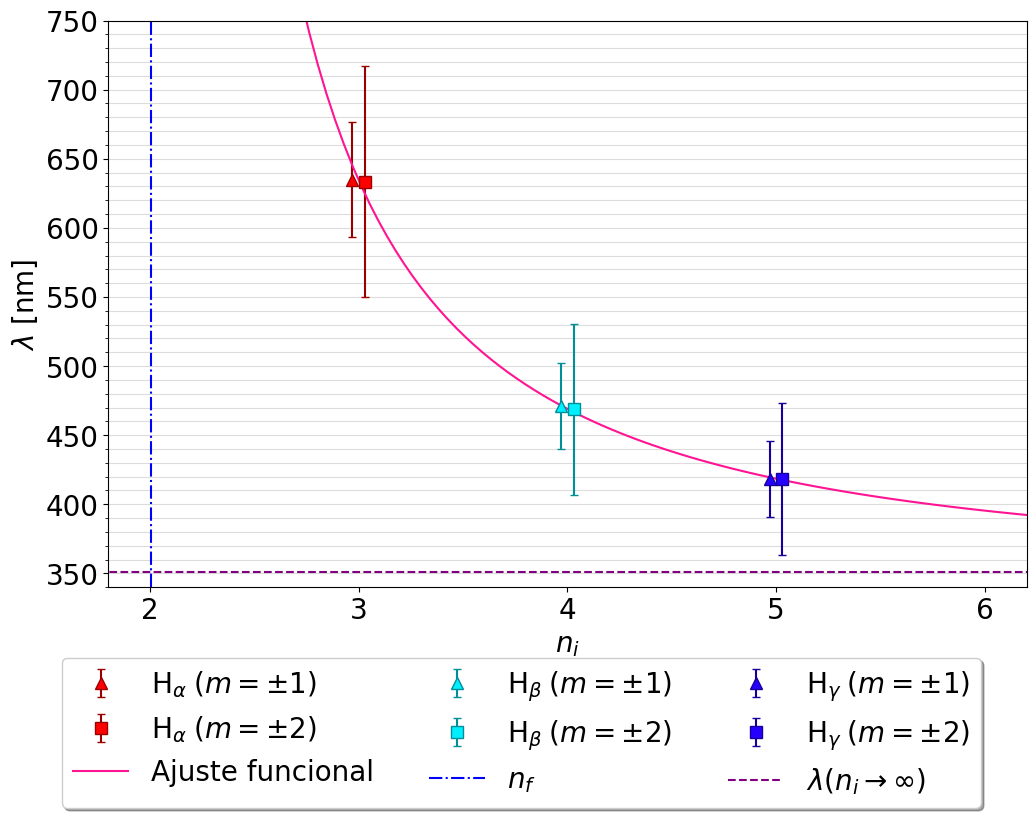

In [29]:
#@title Gráfica del primer ajuste
fig, ax = plt.subplots(figsize=(11.85, 6.4), layout='constrained')
for i in range(len(Ni_grafica)):
  for m in range(len(Ni_grafica[i])):
    ax.errorbar(
      Ni_grafica[i][m],
      lambdas_H_exp[i][m],
      Delta_lambdas_H_exp[i][m],
      capsize=3,
      c=colores[i],
      ecolor=colores_barra[i],
      elinewidth=1.5,
      fmt=marcadores[i][m],
      mec=colores_barra[i],
      ms=8,
      zorder=2,
      label=Labels[i][m]
    )
ax.plot(
  Ni_ajuste,
  lambda_ajuste_1,
  c='deeppink',
  lw=1.5,
  label='Ajuste funcional',
  zorder=2,
)
ax.vlines(x=asintota_vertical_1, ymin=340, ymax=750, ls='-.', lw=1.5, color='b', zorder=2, label='$n_f$')  # Asíntota vertical (n = 2)
ax.hlines(y=asintota_horizontal_1, xmin=1, xmax=6.2, ls='--', lw=1.5, color='purple', zorder=2, label='$\\lambda (n_i \\to \\infty)$')  # Asíntota horizontal (λ(n → ∞))
ax.grid(True, which='both', axis='y', color='gainsboro')
ax.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom=False)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim([1.8, 6.2])
ax.set_ylim([340, 750])
ax.set_xlabel('$n_i$')
ax.set_ylabel('$\\lambda$ [nm]')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])

handles, labels = plt.gca().get_legend_handles_labels()
ordered_handles = [element for i, element in sorted(zip(Label_order_idx, handles))]
ordered_labels = [element for i, element in sorted(zip(Label_order_idx, labels))]
ax.legend(ordered_handles, ordered_labels, loc='upper center', bbox_to_anchor=(0.45, -0.1), fancybox=True, shadow=True, ncol=3, markerscale=1)

#plt.savefig("graficas\\Ajuste_experimental.pdf", format="pdf", bbox_inches='tight')

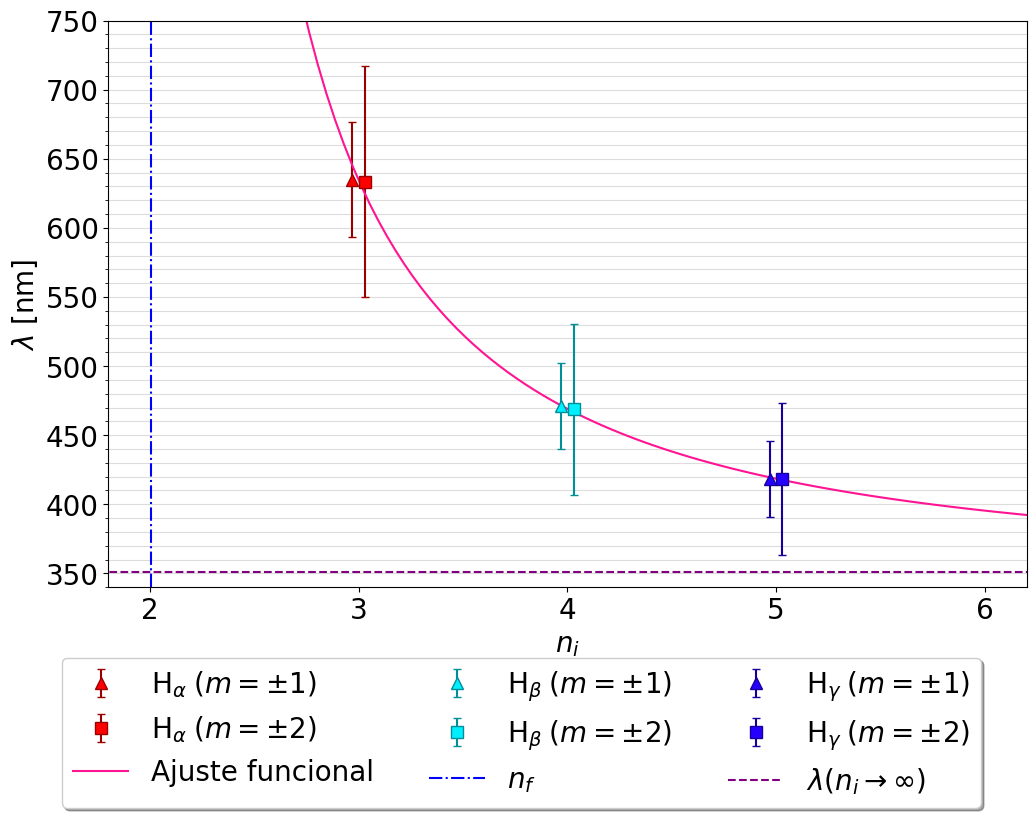

In [30]:
#@title Gráfica del segundo ajuste
fig, ax = plt.subplots(figsize=(11.85, 6.4), layout='constrained')
for i in range(len(Ni_grafica)):
  for m in range(len(Ni_grafica[i])):
    ax.errorbar(
      Ni_grafica[i][m],
      lambdas_H_exp[i][m],
      Delta_lambdas_H_exp[i][m],
      capsize=3,
      c=colores[i],
      ecolor=colores_barra[i],
      elinewidth=1.5,
      fmt=marcadores[i][m],
      mec=colores_barra[i],
      ms=8,
      zorder=2,
      label=Labels[i][m]
    )
ax.plot(
  Ni_ajuste,
  lambda_ajuste_2,
  c='deeppink',
  lw=1.5,
  label='Ajuste funcional',
  zorder=2,
)
ax.vlines(x=asintota_vertical_2, ymin=340, ymax=750, ls='-.', lw=1.5, color='b', zorder=2, label='$n_f$')  # Asíntota vertical (n = 2)
ax.hlines(y=asintota_horizontal_2, xmin=1, xmax=6.2, ls='--', lw=1.5, color='purple', zorder=2, label='$\\lambda (n_i \\to \\infty)$')  # Asíntota horizontal (λ(n → ∞))
ax.grid(True, which='both', axis='y', color='gainsboro')
ax.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom=False)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim([1.8, 6.2])
ax.set_ylim([340, 750])
ax.set_xlabel('$n_i$')
ax.set_ylabel('$\\lambda$ [nm]')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])

handles, labels = plt.gca().get_legend_handles_labels()
ordered_handles = [element for i, element in sorted(zip(Label_order_idx, handles))]
ordered_labels = [element for i, element in sorted(zip(Label_order_idx, labels))]
ax.legend(ordered_handles, ordered_labels, loc='upper center', bbox_to_anchor=(0.45, -0.1), fancybox=True, shadow=True, ncol=3, markerscale=1)

#plt.savefig("graficas\\Ajuste_experimental.pdf", format="pdf", bbox_inches='tight')

In [65]:
#@title Constantes
# https://pml.nist.gov/cgi-bin/cuu/Value?ryd|search_for=Rydberg
R_inf = 0.010973731568157  # [nm⁻¹]
Delta_R_inf = 1.2e-14  # [nm⁻¹]

# https://pml.nist.gov/cgi-bin/cuu/Value?mesmp|search_for=ratio
mass_ratio = 5.446170214889e-4
Delta_mass_ratio = 9.4e-15

R_M = R_inf / (1 + mass_ratio)  # [nm⁻¹]
Delta_R_M = R_M * np.sqrt((Delta_R_inf / R_inf) ** 2 + (Delta_mass_ratio / (1 + mass_ratio)) ** 2)  # [nm⁻¹]

# https://pml.nist.gov/cgi-bin/cuu/Value?h|search_for=universal_in!
h = 6.62607015e-14  # [J s]

# https://pml.nist.gov/cgi-bin/cuu/Value?c|search_for=universal_in!
c = 299792458  # [m / s]

# Factor de conversión de Julios a eV 
# https://pml.nist.gov/cgi-bin/cuu/Value?e|search_for=elecmag_in!
e = 1.602176634e-19  # [J / eV]

In [58]:
#@title Comparación de la constantes de Rydberg experimentales con la teórica
R_1 = a_1
Delta_R_1 = Delta_a_1
R_2 = - a_2
Delta_R_2 = Delta_a_2
R_3 = 4 * b_2
Delta_R_3 = 4 * Delta_b_2

print('Constante de Rydberg para el hidrógeno con la corrección de masa finita')
print(f'R_M = ({R_M} ± {Delta_R_M:.15f}) nm⁻¹')

print('\nConstantes de Rydberg determinadas')
print(f'R_M¹ = ({R_1:7.4f} ± {Delta_R_1:7.4f}) nm⁻¹,     R_∞¹ = ({R_1 * (1 + mass_ratio):6.4f} ± {Delta_R_1 * (1 + mass_ratio):6.4f}) nm⁻¹')
print(f'R_M² = ({R_2:7.4f} ± {Delta_R_2:7.4f}) nm⁻¹,     R_∞² = ({R_2 * (1 + mass_ratio):6.4f} ± {Delta_R_2 * (1 + mass_ratio):6.4f}) nm⁻¹')
print(f'R_M³ = ({R_3:7.5f} ± {Delta_R_3:7.5f}) nm⁻¹,     R_∞³ = ({R_3 * (1 + mass_ratio):6.4f} ± {Delta_R_3 * (1 + mass_ratio):6.4f}) nm⁻¹')

print('\nDiferencia entre las constantes halladas')
print(f'|R_M¹ - R_M²| ≈ {abs(R_1 - R_2):.3e} nm⁻¹')
print(f'|R_M¹ - R_M³| ≈ {abs(R_1 - R_3):.3e} nm⁻¹')
print(f'|R_M² - R_M³| ≈ {abs(R_3 - R_2):.3e} nm⁻¹')

print('\nDiferencia relativa porcentual al valor teórico')  # Se puede factorizar (1 + mass_ratio) en el numerador y denominador
print(f'|R_∞¹ - R_∞|/R_∞ ≈ {abs(R_1 - R_M) / R_M:%}')
print(f'|R_∞² - R_∞|/R_∞ ≈ {abs(R_2 - R_M) / R_M:%}')
print(f'|R_∞³ - R_∞|/R_∞ ≈ {abs(R_3 - R_M) / R_M:%}')

Constante de Rydberg para el hidrógeno con la corrección de masa finita
R_M = (0.010967758340277307 ± 0.000000000000012) nm⁻¹

Constantes de Rydberg determinadas
R_M¹ = ( 0.0114 ±  0.0002) nm⁻¹,     R_∞¹ = (0.0114 ± 0.0002) nm⁻¹
R_M² = ( 0.0114 ±  0.0002) nm⁻¹,     R_∞² = (0.0114 ± 0.0002) nm⁻¹
R_M³ = (0.01139 ± 0.00005) nm⁻¹,     R_∞³ = (0.0114 ± 0.0001) nm⁻¹

Diferencia entre las constantes halladas
|R_M¹ - R_M²| ≈ 1.596e-16 nm⁻¹
|R_M¹ - R_M³| ≈ 5.019e-05 nm⁻¹
|R_M² - R_M³| ≈ 5.019e-05 nm⁻¹

Diferencia relativa porcentual al valor teórico
|R_∞¹ - R_∞|/R_∞ ≈ 4.276271%
|R_∞² - R_∞|/R_∞ ≈ 4.276271%
|R_∞³ - R_∞|/R_∞ ≈ 3.818684%


In [74]:
#@title Arreglos de las series espectrales y niveles de energía
n = np.arange(1, 14)
ni = n + 2

# Longitudes de onda
lambdas_H_teoricos = 1 / (R_M * (0.25 - 1 / ni ** 2))
lambdas_H_experimentales = 1 / (R_3 * (0.25 - 1 / ni ** 2))

lambda_inf_teorico = 4 / R_M
lambda_inf_experimental = 4 / R_3

# Niveles de energía
E_H_teoricos = - (R_M / 1e+11) * h * c / (n * e)
E_H_experimentales = - (R_3 / 1e+11) * h * c / (n * e)

(-0.25, 1.25)

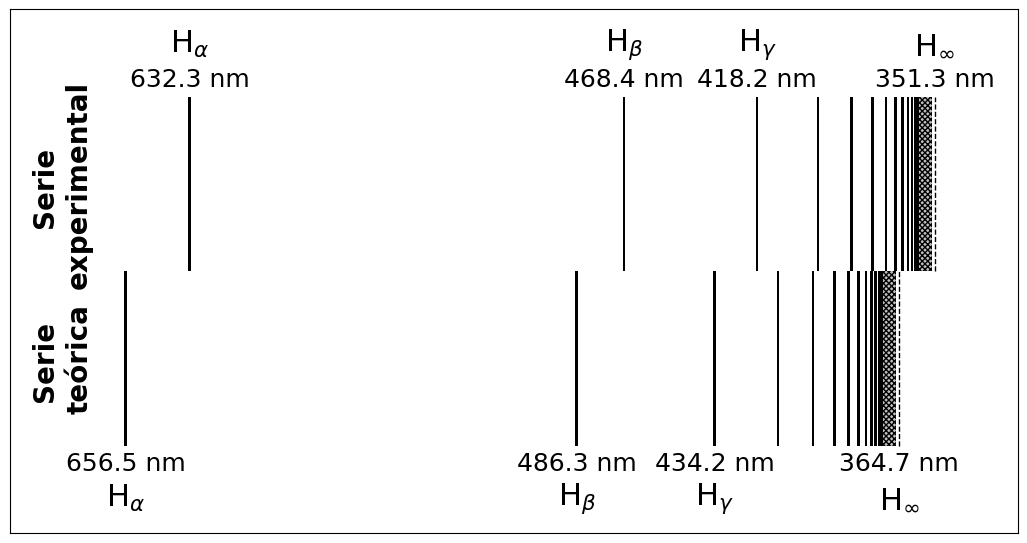

In [143]:
#@title Gráfica de comparación de la serie de Balmer teórica y experimental
plt.figure(figsize=(13, 6.8))

# Serie teórica
plt.bar(700 - lambdas_H_teoricos, 0.5, bottom=0, width=1, color='k', zorder=2)
plt.fill_between(
  [700 - lambdas_H_teoricos[-1], 700 - lambda_inf_teorico - 1],
  y1=0.5,
  lw=0,
  ec='k',
  fc='silver',
  hatch='xxxxxx',
  zorder=1,
)
plt.vlines(700 - lambda_inf_teorico, ymin=0, ymax=0.5, lw=1, color='k', ls='--', zorder=2)
plt.text(20, 0.25, "Serie \nteórica", rotation=90., ha="center", va="center", weight='semibold')

nombres = ["$\\text{H}_\\alpha$", "$\\text{H}_\\beta$", "$\\text{H}_\\gamma$"]
for i, nombre in enumerate(nombres):
  plt.text(700 - lambdas_H_teoricos[i], -.15, nombre, ha="center", va="center", size=22)
  plt.text(700 - lambdas_H_teoricos[i], -.05, f"{lambdas_H_teoricos[i]:.1f} nm", ha="center", va="center", size=18)
plt.text(700 - lambda_inf_teorico, -.15, "$\\text{H}_\\infty$", ha="center", va="center", size=22)
plt.text(700 - lambda_inf_teorico, -.05, f"{lambda_inf_teorico:.1f} nm", ha="center", va="center", size=18)

# Serie experimental (primer ajuste)
plt.bar(700 - lambdas_H_experimentales, 0.5, bottom=0.5, width=1, color='k', zorder=2)
plt.fill_between(
  [700 - lambdas_H_experimentales[-1], 700 - lambda_inf_experimental - 1],
  y1=1,
  y2=0.5,
  lw=0,
  ec='k',
  fc='silver',
  hatch='xxxxxx',
  zorder=1,
)
plt.vlines(700 - lambda_inf_experimental, ymin=0.5, ymax=1, lw=1, color='k', ls='--', zorder=2)
plt.text(20, 0.75, "Serie \nexperimental", rotation=90., ha="center", va="center", weight='semibold')

for i, nombre in enumerate(nombres):
  plt.text(700 - lambdas_H_experimentales[i], 1.15, nombre, ha="center", va="center", size=22)
  plt.text(700 - lambdas_H_experimentales[i], 1.05, f"{lambdas_H_experimentales[i]:.1f} nm", ha="center", va="center", size=18)
plt.text(700 - lambda_inf_experimental, 1.15, "$\\text{H}_\\infty$", ha="center", va="center", size=22)
plt.text(700 - lambda_inf_experimental, 1.05, f"{lambda_inf_experimental:.1f} nm", ha="center", va="center", size=18)

plt.xticks([])
plt.yticks([])
plt.xlim(0, 380)
plt.ylim(-0.25, 1.25)

#plt.savefig("graficas\\Comparacion_series.pdf", format="pdf", bbox_inches='tight')

(-17.0, 1.0)

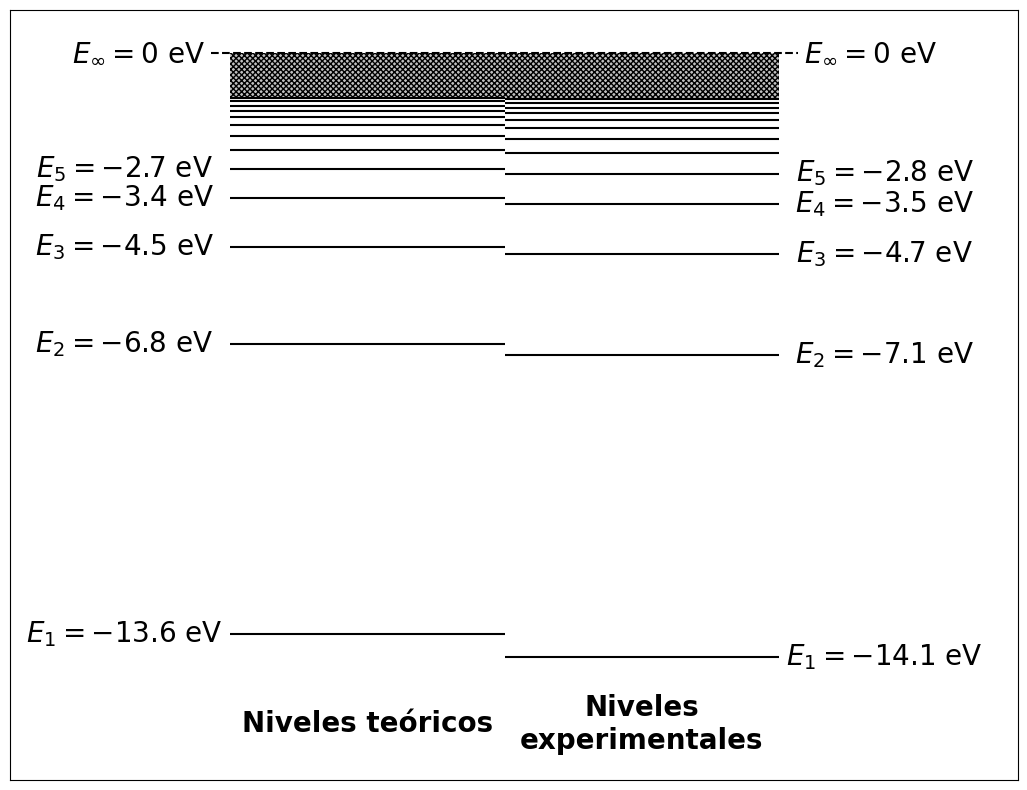

In [145]:
#@title Gráfica de comparación entre niveles de energía de los orbitales del hidrógeno
plt.figure(figsize=(13, 10))

for i, E_H_t, E_H_e in zip(np.arange(len(E_H_teoricos)), E_H_teoricos, E_H_experimentales):
  plt.hlines(E_H_t, 0.2, 0.5, color='k')
  plt.hlines(E_H_e, .5, .8, color='k')
  if i <= 4:
    plt.text(0.085, E_H_t, f'$E_{i+1} = {E_H_t:.1f}$ eV', ha="center", va="center")
    plt.text(0.915, E_H_e, f'$E_{i+1} = {E_H_e:.1f}$ eV', ha="center", va="center")


plt.fill_between(
  [0.2, 0.5],
  y1=0,
  y2=E_H_teoricos[-1],
  lw=0,
  ec='k',
  fc='silver',
  hatch='xxxxxx',
  zorder=1,
)
plt.fill_between(
  [0.5, 0.8],
  y1=0,
  y2=E_H_experimentales[-1],
  lw=0,
  ec='k',
  fc='silver',
  hatch='xxxxxx',
  zorder=1,
)

plt.hlines(0, .18, .82, color='k', ls='--')
plt.text(0.1, 0, '$E_\\infty = 0$ eV', ha="center", va="center")
plt.text(0.9, 0, '$E_\\infty = 0$ eV', ha="center", va="center")

plt.text(0.35, -15.7, 'Niveles teóricos', ha="center", va="center", weight='semibold')
plt.text(0.65, -15.7, 'Niveles\nexperimentales', ha="center", va="center", weight='semibold')

plt.xticks([])
plt.yticks([])
plt.xlim(-0.04, 1.06)
plt.ylim(-17, 1)

#plt.savefig("graficas\\Comparacion_niveles.pdf", format="pdf", bbox_inches='tight')